# Описание проекта

## Цель проекта

Разработать нейросеть, способную определять температуру на поверхности звёз, исходя из их характеристик. В наличие имеются данные по 240 уже изученным звёздам

## Описание данных

Датасет содержит следующие данные по объектам:
* Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
* Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды:

| Тип звезды | Номер, соответствующий типу |
| ---------- | --------------------------- |
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |

* Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

# Загрузка данных

## Импорт библиотек

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from os import path

from fuzzywuzzy import fuzz
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Глобальные переменные

In [3]:
PATH_LOCAL_DATA = './datasets/6_class.csv'
PATH_CLOUD_DATA = '/datasets/6_class_csv'
PATH_DATA_REPORT = './stars-ydata-report.html'
RND = 1337 # random state

## Загрузка датасета

In [4]:
if path.exists(PATH_LOCAL_DATA):
    df = pd.read_csv(PATH_LOCAL_DATA, index_col=0)
    # PATH_PROCESSED_DATA = './datasets/autos_processed.csv'  # path to data after cleaning
    print('Loaded from the local storage.\n')
elif path.exists(PATH_CLOUD_DATA):
    df = pd.read_csv(PATH_CLOUD_DATA, index_col=0)
    # PATH_PROCESSED_DATA = '/datasets/autos_processed.csv'  # path to data after cleaning
    print('Loaded from the remote storage.\n')
else:
    raise ValueError('Unable to load data. Check paths to files.')

display(df.head(3), df.info())

Loaded from the local storage.

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red


None

# Предобработка данных

## Разведывательный анализ

Проведём разведывательный анализ данных с помощью `ydata-profiling`

In [5]:
if path.exists(PATH_DATA_REPORT):
    print('Ydata report already exists. Reporting was skipped.')
else:
    df_profile = ProfileReport(df)
    df_profile.to_widgets()
    df_profile.to_file('stars-ydata-report.html')

Ydata report already exists. Reporting was skipped.


Отчёт выдаёт следующий список предупреждений (алёртов):
* `Temperature (K)` is highly overall correlated with `Absolute magnitude(Mv)` and 1 other fields
* `Luminosity(L/Lo)` is highly overall correlated with `Radius(R/Ro)` and 2 other fields
* `Radius(R/Ro)` is highly overall correlated with `Luminosity(L/Lo)` and 2 other fields
* `Absolute magnitude(Mv)` is highly overall correlated with `Temperature (K)` and 3 other fields
* `Star type` is highly overall correlated with `Temperature (K)` and 4 other fields
* `Star color` is highly overall correlated with `Star type`
* `Star type` has 40 (16.7%) zeros

Последнее предупреждение о том, что `Star type` имеет много нулей, можно игнорировать, потому что в данному случае числа являются категориальными признаками, указывающими на соответствие различным типам звёзд

Рассмотрим подробнее хитмап матрицы корреляций

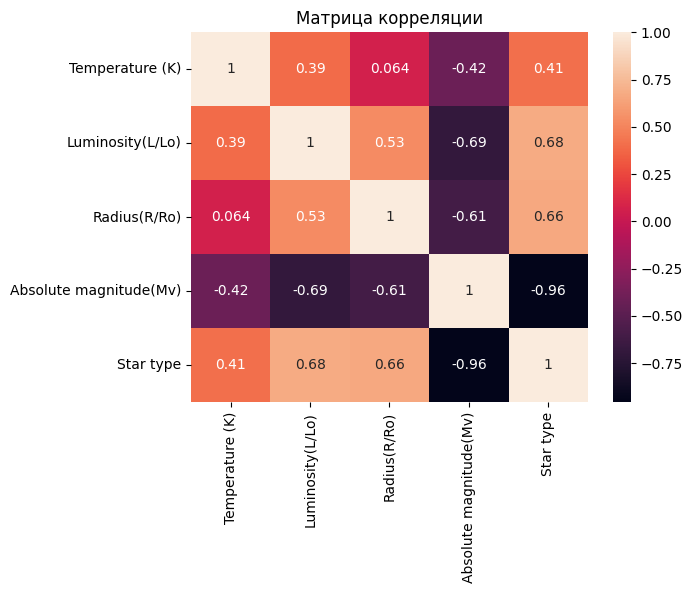

In [6]:
%matplotlib inline
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Матрица корреляции")
plt.show()

Коэффициент корреляции между `Star type` и `Absolute magnitude` очень высокий, но это связано с тем, что категориальный признак представлен числом. Абсолютные значения коэффициентов корреляции этих столбцов по отношению к остальным также очень близки, за исключением знака.

При подробном изучении столбца `Star type` видно что данные по этому столбцу строго стратифицированы: в датасете присутствует по 40 образцов звёзд каждого типа. Кроме того, эти типы звёзд образуют явно выраженную последовательность от сверхгигантов до коричневых карликов, так что они уже кодированы методом по принципу Ordinal Encoding. В связи с этим мы не будем разбивать классы этой категории по принципу OHE

In [7]:
df["Star type"].value_counts()

Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Зависимость между температурой звёзд и абсолютной светимостью похоже на график главной последовательности звёзд

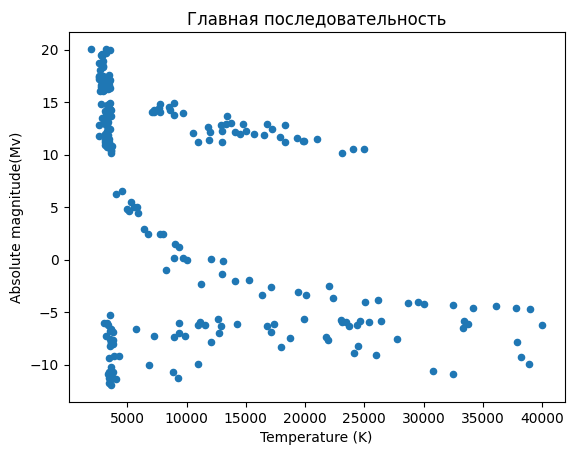

In [8]:
df[["Temperature (K)", "Absolute magnitude(Mv)"]].plot(kind='scatter', x=0, y="Absolute magnitude(Mv)", title="Главная последовательность")
plt.show()

## Подготовка датасета

In [9]:
# переименуем колонки
df.columns = [
    "temperature", "luminosity", "radius", "abs_magnitude", "star_type", "star_color"
]
df.columns

Index(['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type',
       'star_color'],
      dtype='object')

Другой интересный столбец `star_color`. Он содержит информацию о цвете, полученную на основе спектрального анализа. Но текст не приведён к одному формату

In [10]:
df["star_color"].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Что касается самих значений, есть два способа обработать классы, имеющие упоминание нескольких цветов:
* обработать смешанные версии цветов как отдельные категории
* ввести отдельный класс для каждого цвета и присваивать их, исходя из описания цвета
* * например, объект с цветом "Pale yellow orange" будет иметь положительный класс по столбцам с жёлтым и оранжевым цветом

Воспользуемся вторым способом. Чтобы классифицировать цвета, будем считать расстояние Левенштейна с помощью библиотеки `fuzzywuzzy`

In [11]:
# список цветов
colors = ["red", "blue", "yellow", "orange", "white"]

# порог для дистанции
levenshtein_distance = 50

Проверим на всех уникальных значениях столбца `star_color`, насколько корректно сработает выбранный метод

In [12]:
# датафрейм с уникальными значениями цветов
df_colors = pd.DataFrame(df["star_color"].unique(), columns=["color"])

# классификация на основе расстояния Левенштейна
for color in colors:
    df_colors["c_"+color] = df_colors["color"].str.casefold().apply(lambda x: 1 if fuzz.ratio(x, color) >= levenshtein_distance else 0)

df_colors

,color,c_red,c_blue,c_yellow,c_orange,c_white
0,Red,1,0,0,0,0
1,Blue White,0,1,0,0,1
2,White,0,0,0,0,1
3,Yellowish White,0,0,1,0,1
4,Blue white,0,1,0,0,1
5,Pale yellow orange,0,0,1,1,0
6,Blue,0,1,0,0,0
7,Blue-white,0,1,0,0,1
8,Whitish,0,0,0,0,1
9,yellow-white,0,0,1,0,1


Всё работает корректно, применим этот метод к основному датафрейму

In [13]:
for color in colors:
    df["c_"+color] = df["star_color"].str.casefold().apply(lambda x: 1 if fuzz.ratio(x, color) >= levenshtein_distance else 0)

df.head(3)

,temperature,luminosity,radius,abs_magnitude,star_type,star_color,c_red,c_blue,c_yellow,c_orange,c_white
0,3068,0.0024,0.1700,16.12,0,Red,1,0,0,0,0
1,3042,0.0005,0.1542,16.60,0,Red,1,0,0,0,0
2,2600,0.0003,0.1020,18.70,0,Red,1,0,0,0,0


In [14]:
# удаляем стобец с цветом
df = df.drop(columns=["star_color"])
df.head(3)

,temperature,luminosity,radius,abs_magnitude,star_type,c_red,c_blue,c_yellow,c_orange,c_white
0,3068,0.0024,0.1700,16.12,0,1,0,0,0,0
1,3042,0.0005,0.1542,16.60,0,1,0,0,0,0
2,2600,0.0003,0.1020,18.70,0,1,0,0,0,0


Чтобы избежать утечки целевого признака в тестовую выборку, будем стандартизировать данные уже после того, как разделим выборки на тренировочную и тестовую

## Подготовка выборок

### Разделение выборок и скалирование

In [15]:
# разделяем датасет и скалируем цифровые признаки
target_feature = "temperature"
stratify_features = ["star_type"]

df_X, df_y = df.drop(columns=[target_feature]).copy(), df[target_feature].copy()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, stratify=df_X[stratify_features], random_state=RND)

for s in X_train, X_test, y_train, y_test:
    print(s.shape)

(180, 9)
(60, 9)
(180,)
(60,)


In [16]:
# скалирование признаков

scale_features = ['luminosity', 'radius', 'abs_magnitude']

scaler = StandardScaler()
scaler.fit(X_train[scale_features])

for i in X_train, X_test:
    i[scale_features] = scaler.transform(i[scale_features])
    display(i.head())

,luminosity,radius,abs_magnitude,star_type,c_red,c_blue,c_yellow,c_orange,c_white
221,1.378139,-0.309055,-1.065849,4,0,1,0,0,0
225,0.736672,-0.367767,-1.106434,4,0,1,0,0,0
215,0.433145,-0.445586,-0.814788,3,0,1,0,0,0
97,-0.601586,-0.455169,-0.172980,3,0,0,1,0,1
67,-0.601634,-0.457613,1.149335,0,1,0,0,0,0


,luminosity,radius,abs_magnitude,star_type,c_red,c_blue,c_yellow,c_orange,c_white
109,1.494120,-0.326669,-0.949757,4,0,1,0,0,0
136,-0.601634,-0.457322,0.675529,1,1,0,0,0,0
8,-0.601634,-0.457576,1.243719,0,1,0,0,0,0
237,2.598517,2.327102,-1.416012,5,0,0,0,0,1
123,-0.601634,-0.457609,1.193696,0,1,0,0,0,0


In [17]:
# cоздание тензоров
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

## Предварительный вывод

* В датасете нет дубликатов и пропусков, данные в целом чистые
* Распределение магнитуды от температуры похоже на соответствующий график главной последовательности звёзд, что говорит о хорошем качестве данных
* Мы обработали столбец с цветом, выделив в качестве признаков отдельные составляющие спектра
* Мы выполнили стандартизацию числовых признаков
* Столбец с типом звезды дополнительно обрабатывать не стали, поскольку он является порядковым категориальным признаком

# Построение базовой нейронной сети

In [18]:
# будем использовать для воспроизводимости
torch.use_deterministic_algorithms(True)

def reset_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Класс для отображения отчёта

Создадим класс, объекты которого будут собирать данные об обучении, считать метрики и строить графики

In [54]:
# класс для формирования отчётов
class TrainReport():

    # инициирует объект и пустые листы
    def __init__(self) -> None:
        self.epoch = []
        self.loss_train = []
        self.loss_test = []

    # добавляет данные в листы
    def add_to_lists(self, epoch, loss_value_train, loss_value_test):
        self.epoch.append(epoch)
        self.loss_train.append(loss_value_train)
        self.loss_test.append(loss_value_test)
    
    # строит графики
    def report(self, y_preds, y_test, batch_size=1, dropout_value='None'):

        # график обучения
        self.df1 = pd.DataFrame(
            {
                'loss_on_train': np.sqrt(self.loss_train),
                'loss_on_test': np.sqrt(self.loss_test)
            },
            index=self.epoch
        )
        
        self.df1.plot(y=['loss_on_train', 'loss_on_test'], grid=True, title="RMSE.\nBatch size: {}. Dropout: {}".format(batch_size, dropout_value), xlabel="Epochs", ylabel="Loss")
        plt.show()
        
        # график предсказанных значений по каждой звезде
        self.df2 = pd.DataFrame(
            {
                'temp_predicted': y_preds.detach().numpy(),
                'temp_test': y_test.numpy()
            }
        )
        self.df2.plot(kind='bar', grid=True, title="Errors per test item.\nBatch size: {}. Dropout: {}".format(batch_size, dropout_value), xlabel='Test star ID', ylabel='Temperature', figsize=(12, 5))
        plt.show()

        print("Train RMSE:", np.sqrt(self.loss_train[-1]).round())
        print("Test RMSE:", np.sqrt(self.loss_test[-1]).round())

## Обучение baseline модели

In [20]:
# некоторые гиперпараметры
neurons = [9, 10, 6, 1]

In [21]:
# baseline model

class BaselineModel(nn.Module):
    def __init__(self, neurons: list):
        super(BaselineModel, self).__init__()

        self.fc1 = nn.Linear(neurons[0], neurons[1])

        self.fc2 = nn.Linear(neurons[1], neurons[2])

        self.fc3 = nn.Linear(neurons[2], neurons[3])

        self.relu = nn.ReLU()
    
    def forward(self, x):

        out = self.fc1(x)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)
        out = self.relu(out)

        return out

In [22]:
reset_seed(RND)

base_model = BaselineModel(neurons)
base_lr = 0.01
base_loss = nn.MSELoss()
base_optim = torch.optim.Adam(base_model.parameters(), lr=base_lr)

Training...:   0%|          | 0/5000 [00:00<?, ?e/s]

Training...: 100%|██████████| 5000/5000 [00:08<00:00, 585.37e/s]


,loss_on_train,loss_on_test
0,14729.358981,12384.917279
200,10128.825006,8315.317432
400,7087.256451,7082.565919
600,6410.389380,6677.138309
800,6041.285956,6292.463746


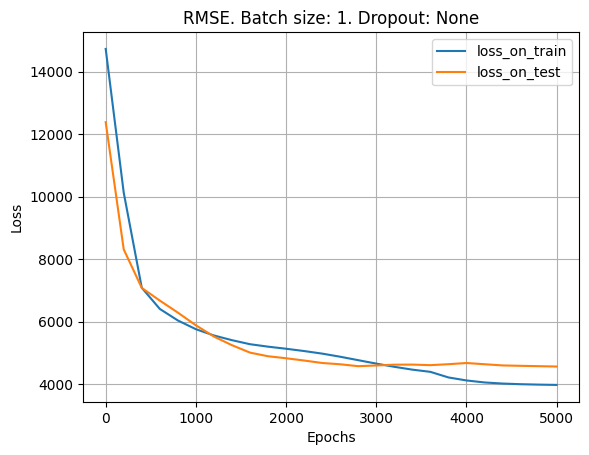

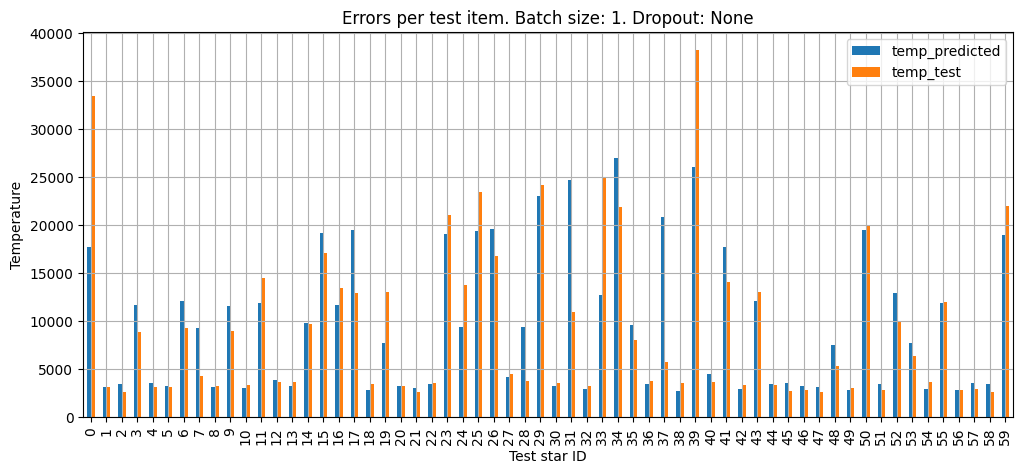

Train RMSE: 3979.0
Test RMSE: 4568.0


In [23]:
base_report = TrainReport()
base_epochs = 5000
reset_seed(RND)

for e in tqdm(range(base_epochs), desc="Training...", unit='e'):
    base_optim.zero_grad()
    preds = base_model.forward(X_train).flatten()
    loss_value = base_loss(preds, y_train)
    loss_value.backward()
    base_optim.step()

    # проверка на тестовой
    if e % 200 == 0 or e == base_epochs - 1:
        base_model.eval()
        test_preds = base_model.forward(X_test).flatten()
        test_loss = base_loss(test_preds, y_test)
        
        base_report.add_to_lists(e, loss_value.item(), test_loss.item())

        base_model.train()

base_model.eval()
base_report.report(test_preds, y_test)

## Предварительный вывод

* В результате экспериментов была получина модель, которая обеспечила значение RMSE = 4568 на тестовой выборке
* График обучение показывает, что в определённый момент модель начинает переобучаться - значение функции потерь на тестовой выборке перестаёт падать (и, если продолжить обучение дальше, начинает расти)
* График ошибок показывает, что обученная модель неплохо справляется с одними данными, но при этом очень сильно ошибается с другими, эта разница возрастает с ростом значения температуры
* Попробуем улучшить данную модель, используя незадействованные методы

# Улучшение базовой нейронной сети

Базовая модель переобучается, лосс на тестовой выборке начинает расти с уменьшением лосса на тренировочной выборке, следовательно, попробуем решить проблемы с обучением:
* Проведём обучение батчами и попробуем разные размеры батча
* Введём инициализацию весов
* Добавим дропаут в первые два слоя

Количество нейронов и функции активации оставим теми же.

In [24]:
# размер батча
batch_size = 10

# тензор датасеты и загрузчик
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)


In [25]:
# новая модель

class Model(nn.Module):
    def __init__(self, neurons: list, dropout_p):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(neurons[0], neurons[1])

        self.fc2 = nn.Linear(neurons[1], neurons[2])

        self.fc3 = nn.Linear(neurons[2], neurons[3])

        self.relu = nn.ReLU()

        self.drop = nn.Dropout(p=dropout_p)
    
    def forward(self, x):

        out = self.fc1(x)
        out = self.relu(out)
        out = self.drop(out)

        out = self.fc2(out)
        out = self.relu(out)
        # out = self.drop(out)

        out = self.fc3(out)
        out = self.relu(out)

        return out

In [47]:
final_report = pd.DataFrame(columns=[x for x in np.arange(0, 0.71, 0.1).round(1)], index=[x for x in range(20, 101, 20)])

final_report

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Batch size: 20 | Dropout coeff: 0.0:   0%|          | 0/1500 [00:00<?, ?e/s]

Batch size: 20 | Dropout coeff: 0.0: 100%|██████████| 1500/1500 [00:22<00:00, 67.24e/s]


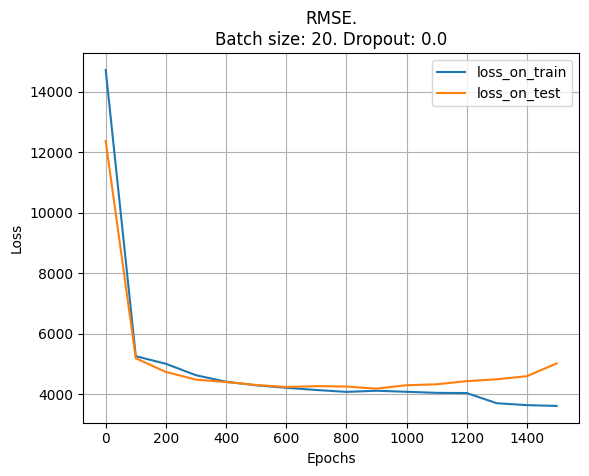

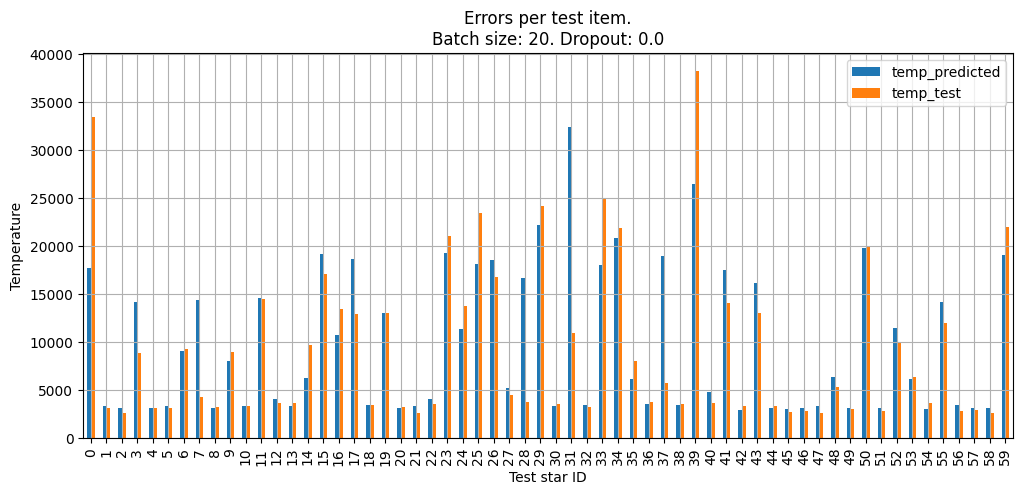

Train RMSE: 3615.0
Test RMSE: 5020.0


In [56]:
epochs = 1500
report_period = 100
lr=0.05

batch_min, batch_max, batch_step = 20, 101, 20
p_min, p_max, p_step = 0, 0.71, 0.1

# таблица для финального отчёта
final_report = pd.DataFrame(
    columns=[x for x in np.arange(p_min, p_max, p_step).round(1)],
    index=[x for x in range(batch_min, batch_max, batch_step)]
)

# размер батча
for batch_size in range(batch_min, batch_max, batch_step):
    
    reset_seed(RND)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        
    # значение дропаут
    for p in np.arange(p_min, p_max, p_step).round(1):
        reset_seed(RND)
        model_report = TrainReport()
        model = Model(neurons=neurons, dropout_p=p)
        loss = nn.MSELoss()
        optim = torch.optim.Adam(model.parameters(), lr=lr)

        # обучение модели
        for e in tqdm(range(epochs), desc="Batch size: {} | Dropout coeff: {}".format(batch_size, p), unit='e'):
            train_loss = []
            for _, (X_batch, y_batch) in enumerate(train_loader):
                optim.zero_grad()
                preds = model(X_batch)
                preds = preds.view(-1)
                loss_value = loss(preds, y_batch)
                train_loss.append(loss_value.item()) # добавляем в лист, чтобы посчитать среднее
                loss_value.backward()
                optim.step()
            if e % report_period == 0 or e == epochs - 1:
                model.eval()

                test_preds = model.forward(X_test).flatten()
                test_loss = loss(test_preds, y_test)
                
                model_report.add_to_lists(e, np.mean(train_loss), test_loss.item())

                model.train()

        model.eval()
        model_report.report(test_preds, y_test, batch_size, p)
        final_report.loc[batch_size, p] = np.sqrt(model_report.loss_test[-1]).round()

final_report.columns = ["Dropout: " + str(x) for x in final_report.columns]
final_report.index = ["Batch size: " + str(x) for x in final_report.index]

# Выводы